In [32]:
using CSV, DataFrames, Distributions, Gadfly, GLM

## 1. Chargement des données

Assurez vous d'avoir télécharger les données dans le répertoire de ce calepin.

In [33]:
data = CSV.read("train.csv")
first(data,5)

5×12 DataFrame. Omitted printing of 6 columns
│ Row │ id    │ radius  │ texture │ perimeter │ area    │ smoothness │
│     │ Int64 │ Float64 │ Float64 │ Float64   │ Float64 │ Float64    │
├─────┼───────┼─────────┼─────────┼───────────┼─────────┼────────────┤
│ 1   │ 1     │ 16.641  │ 21.3452 │ 110.798   │ 901.347 │ 0.112388   │
│ 2   │ 2     │ 13.6884 │ 21.1035 │ 90.5878   │ 578.09  │ 0.0941204  │
│ 3   │ 3     │ 12.9131 │ 14.3055 │ 85.3309   │ 511.539 │ 0.0863069  │
│ 4   │ 4     │ 12.9474 │ 15.1198 │ 86.2821   │ 539.445 │ 0.0925851  │
│ 5   │ 5     │ 19.4972 │ 24.8959 │ 127.491   │ 1200.37 │ 0.101691   │

In [34]:
# Séparation du jeu de données
malign = filter(row -> row.diagnosis == 1, data)
benign = filter(row -> row.diagnosis == 0, data)
n₁ = size(malign, 1)
n₀ = size(benign, 1)
n = n₁ + n₀

455

## 2. Loi prédictive

Après avoir réalisé les calculs pour trouver la loi prédictive pour une loi normale considérant nos a priori non informatifs, on s'assurera qu'elle correspond aussi à une réalisation d'échantillonnage.

In [60]:
loi_inconnue = Normal(5, 2)

Normal{Float64}(μ=5.0, σ=2.0)

In [114]:
n = 100
y = rand.(loi_inconnue for i=1:n)

100-element Array{Float64,1}:
 5.607163761543076  
 2.7655861762593856 
 3.415963395133656  
 3.8576414684460407 
 5.750922015548942  
 6.0243808012816435 
 5.9269965498361605 
 5.877206974065525  
 0.31236128208272707
 2.150950451806988  
 6.090554202323237  
 8.462015690018315  
 5.727275490665743  
 ⋮                  
 1.065101252240391  
 6.883245063360228  
 5.4874465035465105 
 2.2003921188128137 
 4.569076379506509  
 6.78751497207704   
 5.637975641441444  
 2.2255953424147252 
 4.15349685855618   
 5.476510596166008  
 5.416653073439164  
 5.119196037251431  

In [43]:
y = malign[!, :radius]
n = length(y)

171

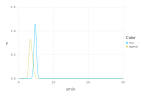

In [115]:
ȳ = mean(y)
SST = sum((y .- ȳ).^2)
s = SST / (n-1)
mμ = LocationScale(ȳ, s/sqrt(n), TDist(n-1))
mσ² = InverseGamma((n-1)/2, 1/2*SST)
plot(
    layer(x -> pdf(mμ, x), 0, 30, color=["mu"]),
    layer(x -> pdf(mσ², x), 0, 30, color=["sigma"])
)

In [116]:
fucked_up_variance = (n+1) * (SST) / (n * (n-2))
dist_pred = LocationScale(ȳ, sqrt(fucked_up_variance), TDist(n-2))

LocationScale{Float64,TDist{Float64}}(
μ: 4.734961533864532
σ: 1.8714339424104307
ρ: TDist{Float64}(ν=98.0)
)


In [117]:
# Gibbs avec densités marginales
quantity = 1000000
ỹ = zeros(quantity)
for i=1:quantity
    μ_rand = rand(mμ)
    σ_rand = sqrt(rand(mσ²))
    ỹ[i] = rand(Normal(μ_rand, σ_rand))
end

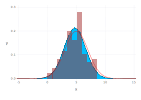

In [118]:
plot(
    layer(x=y, alpha=[0.5],Geom.histogram(bincount=floor(sqrt(n)), density=true), Theme(default_color=colorant"brown")),
    layer(x -> pdf(dist_pred, x), -30, 30, Theme(default_color=colorant"black")),
    layer(x -> pdf(loi_inconnue, x), -30, 30, Theme(default_color=colorant"red")),
    layer(x=ỹ, Geom.histogram(bincount=floor(sqrt(quantity)), density=true)),
    Coord.cartesian(xmin=-5, xmax=15)
)

En noir : loi prédictive <br>
En rouge: loi inconnue <br>
En bleu: valeurs d'échantillonnage <br>

In [119]:
cond_μ(σ::Real) = Normal(ȳ, σ/sqrt(n))
cond_σ²(μ::Real)= InverseGamma(n/2, sum((y .- μ).^2)/2)

cond_σ² (generic function with 1 method)

In [120]:
# Gibbs avec loi conditionnelles complètes
quantity = 100000
ỹ = zeros(quantity)
μ_rand = 5
σ²_rand = 2
for i=1:quantity
    μ_rand = rand(cond_μ(σ²_rand))
    σ²_rand = rand(cond_σ²(μ_rand))
    ỹ[i] = rand(Normal(μ_rand, sqrt(σ²_rand)))
end

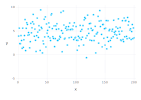

In [121]:
# La phase de chauffe semble très brève
plot(x=1:200, y=ỹ[1:200])

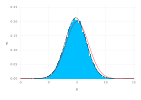

In [122]:
plot(
    layer(x -> pdf(dist_pred, x), -5, 15, Theme(default_color=colorant"black")),
    layer(x -> pdf(loi_inconnue, x), -5, 15, Theme(default_color=colorant"red")),
    layer(x=ỹ, Geom.histogram(bincount=floor(sqrt(quantity)), density=true)),
)

## 3. Application des lois aux données

Pour chaque attribut, on représentera la distribution prédictive.

In [93]:
# Calcul du modèle
function loi_predictive(dataset::Array{Float64})
    ȳ = mean(dataset)
    n = length(dataset)
    SST = sum((dataset .- ȳ).^2)
    fucked_up_variance = (n+1) * (SST) / (n * (n-2))
    return LocationScale(ȳ, sqrt(fucked_up_variance), TDist(n-2))
end

loi_predictive (generic function with 1 method)

In [94]:
n = length(data[!, :id])

455

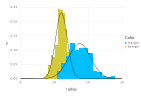

In [95]:
tag = :radius
pred_radius_0 = loi_predictive(benign[!, tag])
pred_radius_1 = loi_predictive(malign[!, tag])
pred_fit_
plot(
    layer(x->pdf(pred_radius_0, x), 0, 30, Theme(default_color=colorant"black")),
    layer(x->pdf(pred_radius_1, x), 0, 30, Theme(default_color=colorant"black")),
    layer(malign, x=tag, Geom.histogram(bincount=floor(sqrt(n₁)), density=true), color = ["malign"]),
    layer(benign, x=tag, alpha=[0.75], Geom.histogram(bincount=floor(sqrt(n₀)), density=true), color = ["benign"])
)

In [96]:
tags = [:radius,:texture,:perimeter,:area,:smoothness,:compactness,
    :concavity,:concave_points,:symmetry,:fractal_dimension]
plots = []
for tag in tags
    pred_0 = loi_predictive(benign[!, tag])
    pred_1 = loi_predictive(malign[!, tag])
    max₀ = maximum(benign[!, tag])
    max₁ = maximum(malign[!, tag])
    push!(plots, plot(
        layer(x->pdf(pred_0, x), 0, 1.2 * max₀, Theme(default_color=colorant"black")),
        layer(x->pdf(pred_1, x), 0, 1.2 * max₁, Theme(default_color=colorant"black")),
        layer(malign, x=tag, Geom.histogram(bincount=floor(sqrt(n₁)), density=true), color = ["malign"]),
        layer(benign, x=tag, Geom.histogram(bincount=floor(sqrt(n₀)), density=true), color = ["benign"])
    ))
end

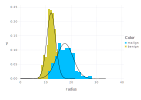

In [97]:
plots[1]

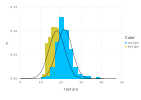

In [20]:
plots[2]

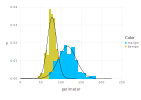

In [21]:
plots[3]

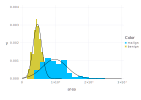

In [22]:
plots[4]

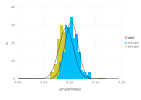

In [23]:
plots[5]

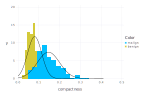

In [24]:
plots[6]

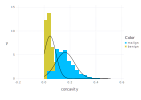

In [25]:
plots[7]

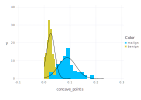

In [26]:
plots[8]

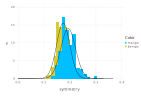

In [27]:
plots[9]

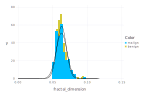

In [28]:
plots[10]

## 4. Probabilité d'une tumeur maligne

On utilisera un modèle bayésien naïf à plusieurs variables pour déterminer si une tumeur est maligne ou bénigne